In [1]:
import tensorflow as tf
tf.__version__

'2.4.0'

In [2]:
import tensorflow
from keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras import layers
from tensorflow.keras import Model
from keras.models import load_model, Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import  BatchNormalization
from keras.models import Model
from tensorflow.keras.models import Model, load_model
from __future__ import print_function, division
from builtins import range, input
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
from glob import glob
import pandas as pd

import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [5]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [6]:
fid = drive.ListFile({'q':"title='dataforcodexray.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('dataforcodexray.zip')

In [7]:
f.keys()

dict_keys(['id', 'kind', 'etag', 'selfLink', 'webContentLink', 'alternateLink', 'embedLink', 'iconLink', 'title', 'mimeType', 'labels', 'copyRequiresWriterPermission', 'createdDate', 'modifiedDate', 'modifiedByMeDate', 'lastViewedByMeDate', 'markedViewedByMeDate', 'version', 'parents', 'downloadUrl', 'userPermission', 'originalFilename', 'fileExtension', 'md5Checksum', 'fileSize', 'quotaBytesUsed', 'ownerNames', 'owners', 'lastModifyingUserName', 'lastModifyingUser', 'capabilities', 'editable', 'copyable', 'writersCanShare', 'shared', 'explicitlyTrashed', 'appDataContents', 'headRevisionId', 'spaces'])

In [8]:
!unzip dataforcodexray.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataforcodexray/test/pneumonia/person103_virus_190.jpeg  
  inflating: dataforcodexray/test/pneumonia/person104_virus_191.jpeg  
  inflating: dataforcodexray/test/pneumonia/person105_virus_192.jpeg  
 extracting: dataforcodexray/test/pneumonia/person105_virus_193.jpeg  
 extracting: dataforcodexray/test/pneumonia/person106_virus_194.jpeg  
  inflating: dataforcodexray/test/pneumonia/person107_virus_197.jpeg  
  inflating: dataforcodexray/test/pneumonia/person108_virus_199.jpeg  
  inflating: dataforcodexray/test/pneumonia/person108_virus_200.jpeg  
  inflating: dataforcodexray/test/pneumonia/person108_virus_201.jpeg  
  inflating: dataforcodexray/test/pneumonia/person109_virus_203.jpeg  
  inflating: dataforcodexray/test/pneumonia/person10_bacteria_43.jpeg  
  inflating: dataforcodexray/test/pneumonia/person110_virus_205.jpeg  
  inflating: dataforcodexray/test/pneumonia/person110_virus_206.jpeg  
  inflating: dataforcodex

In [9]:
PATH = '/content/dataforcodexray'
os.listdir(PATH)
train_dir = os.path.join(PATH,
                         'train')
test_dir = os.path.join(PATH,
                        'test')
train_normal_dir = os.path.join(train_dir,
                                'normal')
train_pneumonia_dir = os.path.join(train_dir,
                                   'pneumonia')
train_covid19_dir = os.path.join(train_dir,
                               'covid-19')

test_normal_dir = os.path.join(test_dir,
                               'normal')
test_pneumonia_dir = os.path.join(test_dir,
                                  'pneumonia')
test_covid19_dir = os.path.join(test_dir,
                              'covid-19')
len(os.listdir(train_normal_dir))


1500

In [10]:
image_gen = ImageDataGenerator(
    rescale=1./255
    )

In [11]:
train_data_gen = image_gen.flow_from_directory(
    #batch_size=batch_size,
    directory=train_dir,
    shuffle=True,
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical')

Found 4500 images belonging to 3 classes.


In [12]:
test_data_gen = image_gen.flow_from_directory(
    #batch_size=batch_size,
    directory=test_dir,
    target_size=(224, 224),
    batch_size=128,
    class_mode='categorical')

Found 1472 images belonging to 3 classes.


In [13]:
from keras.applications import ResNet50
resModel = ResNet50(input_shape=(224,224,3), weights='imagenet', include_top=False)


94773248/94765736 [==============================] - 1s 0us/step


In [19]:

outputs = resModel.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.5)(outputs)
outputs = Dense(3, activation="softmax")(outputs)

model = Model(inputs=resModel.input, outputs=outputs)

for layer in resModel.layers:
    layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

In [20]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [21]:
batch_size = 128
epochs = 100

In [22]:
num_pneumonia_train = len(os.listdir(train_pneumonia_dir))
num_normal_train = len(os.listdir(train_normal_dir))
num_covid19_train = len(os.listdir(train_covid19_dir))

num_pneumonia_test = len(os.listdir(test_pneumonia_dir))
num_normal_test = len(os.listdir(test_normal_dir))
num_covid19_test = len(os.listdir(test_covid19_dir))

total_train = num_normal_train + num_pneumonia_train + num_covid19_train
total_test = num_normal_test + num_pneumonia_test + num_covid19_test

In [23]:
history=model.fit_generator(train_data_gen,
         steps_per_epoch = total_train // batch_size,
         epochs = epochs,
         validation_data = test_data_gen
       
         )

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
35/35 [==============================] - 136s 4s/step - loss: 4.2147 - accuracy: 0.3658 - val_loss: 0.6588 - val_accuracy: 0.7058
Epoch 2/100
35/35 [==============================] - 134s 4s/step - loss: 0.8580 - accuracy: 0.6083 - val_loss: 0.5511 - val_accuracy: 0.8105
Epoch 3/100
35/35 [==============================] - 134s 4s/step - loss: 0.7054 - accuracy: 0.6778 - val_loss: 0.5259 - val_accuracy: 0.7670
Epoch 4/100
35/35 [==============================] - 135s 4s/step - loss: 0.5998 - accuracy: 0.7452 - val_loss: 0.5377 - val_accuracy: 0.8159
Epoch 5/100
35/35 [==============================] - 131s 4s/step - loss: 0.8341 - accuracy: 0.6633 - val_loss: 0.4817 - val_accuracy: 0.8173
Epoch 6/100
35/35 [==============================] - 135s 4s/step - loss: 0.5564 - accuracy: 0.7622 - val_loss: 0.5167 - val_accuracy: 0.7568
Epoch 7/100
35/35 [==============================] - 134s 4s/step - loss: 0.5755 - accuracy: 0.7537 - val_loss: 0.5099 - val_accuracy: 0.7914
Epoch 

In [24]:
import plotly.graph_objects as go
fig = go.Figure()

fig.add_trace(go.Scatter(x=history.epoch,
                         y=history.history['accuracy'],
                         mode='lines+markers',
                         name='Training accuracy'))
fig.add_trace(go.Scatter(x=history.epoch,
                         y=history.history['val_accuracy'],
                         mode='lines+markers',
                         name='Validation accuracy'))
fig.update_layout(title='Accuracy',
                  xaxis=dict(title='Epoch'),
                  yaxis=dict(title='Percentage'))
fig.show()

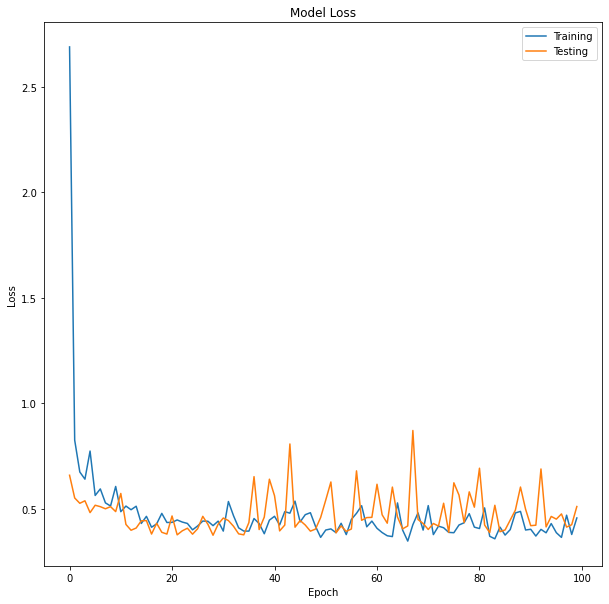

In [25]:
plt.figure(figsize=(10,10))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])